In [41]:
import torch
import numpy as np
import pandas as pd

from torch_geometric.loader import DataLoader
from sklearn.metrics import accuracy_score, precision_score, f1_score, roc_auc_score, cohen_kappa_score

import torch.nn as nn
import torch_geometric.nn as geom_nn

from torch.optim import lr_scheduler
from scipy.optimize import brentq
import matplotlib.pyplot as plt
import time
import copy


In [42]:
class GNNModel(nn.Module):
    def __init__(
        self,
        c_in,
        c_hidden,
        c_out,
        num_layers=2,
        layer_name="GCN",
        dp_rate=0.1,
        **kwargs,
    ):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of the output features. Usually number of classes in classification
            num_layers: Number of "hidden" graph layers
            layer_name: String of the graph layer to use
            dp_rate: Dropout rate to apply throughout the network
            kwargs: Additional arguments for the number of heads for GAT
        """
        super().__init__()

        gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

        gnn_layer = gnn_layer_by_name[layer_name]

        layers = []
        in_channels, out_channels = c_in, c_hidden
        for l_idx in range(num_layers - 1):
            layers += [
                gnn_layer(in_channels=in_channels, out_channels=out_channels, **kwargs),
                nn.ReLU(inplace=True),
                nn.Dropout(dp_rate),
            ]
            in_channels = c_hidden
        layers += [gnn_layer(in_channels=in_channels, out_channels=c_out, **kwargs)]
        self.layers = nn.ModuleList(layers)


    def forward(self, x, edge_index):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
        """
        for layer in self.layers:
            # For graph layers, we need to add the "edge_index" tensor as additional input
            if isinstance(layer, geom_nn.MessagePassing):
                x = layer(x, edge_index)
            else:
                x = layer(x)

        return x

In [43]:


def train_model(model, criterion, optimizer, scheduler, dataloaders,
                dataset_sizes, device, track_out, num_epochs=8):
    """

    :param model: initialized model to train
    :param criterion: loss function
    :param dataloaders: dictionary of dataloaders for training and validation
    :param dataset_sizes: dictionary of dataset sizes for training and validation
    :param device: CPU or GPU to train on
    :param track_out: whether or not to track the running accuracy and loss (for later plotting)
    :param num_epochs:
    :return: model, optimizer, best accuracy, best loss (optionally also running training/validation
    los and accuracy)
    """
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_optim = copy.deepcopy(optimizer.state_dict())
    best_acc = 0.0
    best_loss = float("inf")

    if track_out:
        train_loss = []
        train_acc = []
        track_cohen= []
        track_epochs = []
        # for plotting later
        val_loss = []
        val_acc = []
    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()  # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            probs = []
            label_list = []
            for data in dataloaders[phase]:
                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):

                    outputs = model(data.x, data.edge_index, data.batch)
                    outputs = outputs.squeeze(dim=-1)

                    data.y = data.y.float()
                    loss = criterion(outputs, data.y)

                    # propagate loss and step optimizer if in training stage
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    probs.extend(outputs.detach().cpu())
                    label_list.extend(data.y.detach().cpu())

                # get loss
                running_loss += loss.item() * data.y.size(0)


            # update the learning rate if this is training iteration

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_auprc = roc_auc_score(label_list, probs)
            cohen=cohen_kappa_score(label_list, np.array(probs) > 0.5)
            accuracy = accuracy_score(label_list, np.array(probs) > 0.5)

            if phase == 'train':
                scheduler.step(epoch_loss)
                track_epochs.append(epoch+1)
                track_cohen.append(cohen)
                if epoch%5 == 0:
                    plt.plot(track_epochs, track_cohen, label='Cohen Kappa')
                    plt.show()
                
            if track_out:
                if phase == "train":
                    train_loss.append(epoch_loss)
                    train_acc.append(epoch_auprc)

                else:
                    val_loss.append(epoch_loss)
                    val_acc.append(epoch_auprc)

            print(f'{phase} Loss: {epoch_loss:.4f} ROC AUC: {epoch_auprc:.4f}')
            print(f'{phase} Cohen Kappa: {cohen:.4f}, Accuracy: {accuracy:.4f}, lr: {optimizer.param_groups[0]["lr"]:.6f}')

            # save model if accuracy has improved
            if phase == 'val' and epoch_loss < best_loss:
                best_auprc = epoch_auprc
                best_model_wts = copy.deepcopy(model.state_dict())
                best_optim = copy.deepcopy(optimizer.state_dict())
                best_loss = epoch_loss

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val AUPRC: {epoch_auprc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    optimizer.load_state_dict(best_optim)

    if track_out:
        return model, optimizer, best_auprc, best_loss, train_acc, train_loss, val_acc, val_loss

    return model, optimizer, best_auprc, best_loss



In [44]:

gnn_layer_by_name = {"GCN": geom_nn.GCNConv, "GAT": geom_nn.GATConv, "GraphConv": geom_nn.GraphConv}

class GNNClassifier(nn.Module):
    def __init__(self, c_in, c_hidden, c_out, layer_name, dp_rate_linear=0.5, **kwargs):
        """
        Args:
            c_in: Dimension of input features
            c_hidden: Dimension of hidden features
            c_out: Dimension of output features (usually number of classes)
            dp_rate_linear: Dropout rate before the linear layer (usually much higher than inside the GNN)
            kwargs: Additional arguments for the GNNModel object
        """
        super().__init__()
        self.GNN = GNNModel(c_in=c_in, c_hidden=c_hidden, c_out=c_hidden, num_layers= 2, layer_name=layer_name, dp_rate = 0.1, **kwargs)  # Not our prediction output yet!
        self.head = nn.Sequential(nn.Dropout(dp_rate_linear), nn.Linear(c_hidden, c_out), nn.Sigmoid())


    def forward(self, x, edge_index, batch_idx):
        """
        Args:
            x: Input features per node
            edge_index: List of vertex index pairs representing the edges in the graph (PyTorch geometric notation)
            batch_idx: Index of batch element for each node
        """
        x = self.GNN(x, edge_index)
        x = geom_nn.global_max_pool(x, batch_idx)  # Average pooling
        x = self.head(x)
        return x

In [45]:
def plot_metrics(tloss, vloss, tacc, vacc, save = None):
    # plot training and validation loss
    plt.figure()
    x = range(1, len(tloss) + 1)
    plt.plot(x, tloss, label="Training Loss")
    plt.plot(x, vloss, label="Validation Loss")
    plt.legend()
    if not save:
        plt.show()
    else:
        plt.savefig(save + 'loss.png')

    # plot training and validation accuracy
    plt.figure()
    plt.plot(x, tacc, label="Training AUPRC")
    plt.plot(x, vacc, label="Validation AUPRC")
    plt.legend()
    if not save:
        plt.show()
    else:
        plt.savefig(save + "auprc.png")

def inference_model(model, dataloader):

    model.eval()  # Set model to evaluate mode

    probs = []
    label_list = []

    for data in dataloader:
        # forward
        # track history if only in train
        with torch.set_grad_enabled(False):
            outputs = model(data.x, data.edge_index, data.batch)
            outputs = outputs.squeeze(dim=-1)

            data.y = data.y.float()

            probs.extend(outputs.detach().cpu())
            label_list.extend(data.y.detach().cpu())

    return probs, label_list

Annexe/Preparation data (conversion en graphe)

In [46]:
from torch.utils.data import Dataset
import seaborn as sns
import numpy as np
from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem.rdmolops import GetAdjacencyMatrix
from torch_geometric.data import Data


In [47]:
def one_hot_encoding(x, permitted_list):
    """
    Maps input elements x which are not in the permitted list to the last element
    of the permitted list.
    """
    if x not in permitted_list:
        x = permitted_list[-1]
    binary_encoding = [int(boolean_value) for boolean_value in list(map(lambda s: x == s, permitted_list))]
    return binary_encoding


def get_atom_features(atom,
                      use_chirality=True,
                      hydrogens_implicit=True):
    """
    Takes an RDKit atom object as input and gives a 1d-numpy array of atom features as output.
    """

    # define list of permitted atoms

    permitted_list_of_atoms = ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As', 'Al', 'I',
                               'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se', 'Ti', 'Zn', 'Li', 'Ge',
                               'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr', 'Pt', 'Hg', 'Pb', 'Unknown']

    if hydrogens_implicit == False:
        permitted_list_of_atoms = ['H'] + permitted_list_of_atoms

    # compute atom features

    atom_type_enc = one_hot_encoding(str(atom.GetSymbol()), permitted_list_of_atoms)

    n_heavy_neighbors_enc = one_hot_encoding(int(atom.GetDegree()), [0, 1, 2, 3, 4, "MoreThanFour"])

    formal_charge_enc = one_hot_encoding(int(atom.GetFormalCharge()), [-3, -2, -1, 0, 1, 2, 3, "Extreme"])

    hybridisation_type_enc = one_hot_encoding(str(atom.GetHybridization()),
                                              ["S", "SP", "SP2", "SP3", "SP3D", "SP3D2", "OTHER"])

    is_in_a_ring_enc = [int(atom.IsInRing())]

    is_aromatic_enc = [int(atom.GetIsAromatic())]

    atomic_mass_scaled = [float((atom.GetMass() - 10.812) / 116.092)]

    vdw_radius_scaled = [float((Chem.GetPeriodicTable().GetRvdw(atom.GetAtomicNum()) - 1.5) / 0.6)]

    covalent_radius_scaled = [float((Chem.GetPeriodicTable().GetRcovalent(atom.GetAtomicNum()) - 0.64) / 0.76)]

    atom_feature_vector = atom_type_enc + n_heavy_neighbors_enc + formal_charge_enc + hybridisation_type_enc + is_in_a_ring_enc + is_aromatic_enc + atomic_mass_scaled + vdw_radius_scaled + covalent_radius_scaled

    if use_chirality == True:
        chirality_type_enc = one_hot_encoding(str(atom.GetChiralTag()),
                                              ["CHI_UNSPECIFIED", "CHI_TETRAHEDRAL_CW", "CHI_TETRAHEDRAL_CCW",
                                               "CHI_OTHER"])
        atom_feature_vector += chirality_type_enc

    if hydrogens_implicit == True:
        n_hydrogens_enc = one_hot_encoding(int(atom.GetTotalNumHs()), [0, 1, 2, 3, 4, "MoreThanFour"])
        atom_feature_vector += n_hydrogens_enc

    return np.array(atom_feature_vector)


def get_bond_features(bond,
                      use_stereochemistry=True):
    """
    Takes an RDKit bond object as input and gives a 1d-numpy array of bond features as output.
    """

    permitted_list_of_bond_types = [Chem.rdchem.BondType.SINGLE, Chem.rdchem.BondType.DOUBLE,
                                    Chem.rdchem.BondType.TRIPLE, Chem.rdchem.BondType.AROMATIC]

    bond_type_enc = one_hot_encoding(bond.GetBondType(), permitted_list_of_bond_types)

    bond_is_conj_enc = [int(bond.GetIsConjugated())]

    bond_is_in_ring_enc = [int(bond.IsInRing())]

    bond_feature_vector = bond_type_enc + bond_is_conj_enc + bond_is_in_ring_enc

    if use_stereochemistry == True:
        stereo_type_enc = one_hot_encoding(str(bond.GetStereo()), ["STEREOZ", "STEREOE", "STEREOANY", "STEREONONE"])
        bond_feature_vector += stereo_type_enc

    return np.array(bond_feature_vector)


def create_scaffold_split(df, seed, frac, entity):
    # reference: https://github.com/chemprop/chemprop/blob/master/chemprop/data/scaffold.py
    try:
        from rdkit import Chem
        from rdkit.Chem.Scaffolds import MurckoScaffold
        from rdkit import RDLogger
        RDLogger.DisableLog('rdApp.*')
    except:
        raise ImportError("Please install rdkit by 'conda install -c conda-forge rdkit'! ")
    from tqdm import tqdm
    from random import Random

    from collections import defaultdict
    random = Random(seed)

    s = df[entity].values
    scaffolds = defaultdict(set)
    idx2mol = dict(zip(list(range(len(s))), s))

    error_smiles = 0
    for i, smiles in tqdm(enumerate(s), total=len(s)):
        try:
            scaffold = MurckoScaffold.MurckoScaffoldSmiles(mol=Chem.MolFromSmiles(smiles), includeChirality=False)
            scaffolds[scaffold].add(i)
        except:
            print(smiles + ' returns RDKit error and is thus omitted...')
            error_smiles += 1

    train, val, test, cal = [], [], [], []
    train_size = int((len(df) - error_smiles) * frac[0])
    val_size = int((len(df) - error_smiles) * frac[1])
    cal_size = int((len(df) - error_smiles) * frac[2])
    test_size = (len(df) - error_smiles) - train_size - val_size - cal_size
    train_scaffold_count, val_scaffold_count, cal_scaffold_count, test_scaffold_count = 0, 0, 0, 0

    # index_sets = sorted(list(scaffolds.values()), key=lambda i: len(i), reverse=True)
    index_sets = list(scaffolds.values())
    big_index_sets = []
    small_index_sets = []
    for index_set in index_sets:
        if len(index_set) > val_size / 2 or len(index_set) > test_size / 2:
            big_index_sets.append(index_set)
        else:
            small_index_sets.append(index_set)
    random.seed(seed)
    random.shuffle(big_index_sets)
    random.shuffle(small_index_sets)
    index_sets = big_index_sets + small_index_sets

    if frac[2] == 0:
        for index_set in index_sets:
            if len(train) + len(index_set) <= train_size:
                train += index_set
                train_scaffold_count += 1
            else:
                val += index_set
                val_scaffold_count += 1
    else:
        for index_set in index_sets:
            if len(train) + len(index_set) <= train_size:
                train += index_set
                train_scaffold_count += 1
            elif len(val) + len(index_set) <= val_size:
                val += index_set
                val_scaffold_count += 1

            elif len(cal) + len(index_set) < cal_size:
                cal += index_set
                cal_scaffold_count += 1
            else:
                test += index_set
                test_scaffold_count += 1

    return {'train': df.iloc[train].reset_index(drop=True),
            'valid': df.iloc[val].reset_index(drop=True),
            'cal': df.iloc[cal].reset_index(drop=True),
            'test': df.iloc[test].reset_index(drop=True)}


def label_dist(y, filename, name = None):


    median = np.median(y)
    mean = np.mean(y)

    f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, gridspec_kw= {"height_ratios": (0.15, 1)})

    if name is None:
        sns.boxplot(y, ax=ax_box).set_title("Label Distribution")
    else:
        sns.boxplot(y, ax=ax_box).set_title("Label Distribution of " + str(name) + " Dataset")
    ax_box.axvline(median, color='b', linestyle='--')
    ax_box.axvline(mean, color='g', linestyle='--')
    ax_hist.axvline(median, color='b', linestyle='--')
    ax_hist.axvline(mean, color='g', linestyle='--')
    ax_hist.legend({'Median':median,'Mean':mean})
    sns.distplot(y, ax=ax_hist)
    ax_box.set(xlabel='')
    plt.savefig(filename)


def balanced(val, oversample=False, seed=42):

    class_ = val.Y.value_counts().keys().values
    major_class = class_[0]
    minor_class = class_[1]

    if not oversample:
        print(
            " Subsample the majority class is used, if you want to do "
            "oversample the minority class, set 'balanced(oversample = True)'. ",
            flush=True, file=sys.stderr)
        val = pd.concat(
            [val[val.Y == major_class].sample(
                n=len(val[val.Y == minor_class]), replace=False,
                random_state=seed), val[val.Y == minor_class]]).sample(
            frac=1,
            replace=False,
            random_state=seed).reset_index(
            drop=True)
    else:
        print(" Oversample of minority class is used. ", flush=True,
              file=sys.stderr)
        val = pd.concat(
            [val[val.Y == minor_class].sample(
                n=len(val[val.Y == major_class]), replace=True,
                random_state=seed), val[val.Y == major_class]]).sample(
            frac=1,
            replace=False,
            random_state=seed).reset_index(
            drop=True)
    return val

In [48]:
class MoleculeDataset(Dataset):
    def __init__(self, df, smiles_col='smiles', label_col=None):
        """
        Args:
            df (DataFrame): un DataFrame contenant une colonne SMILES et (optionnellement) une colonne label.
            smiles_col (str): nom de la colonne contenant les SMILES.
            label_col (str or None): nom de la colonne contenant les labels. Si None, pas de label (ex: pour test).
        """
        self.df = df
        self.smiles = df[smiles_col].tolist()
        self.has_labels = label_col is not None
        self.labels = df[label_col].tolist() if self.has_labels else [0]*len(self.smiles)  # fake labels if none

    def __len__(self):
        return len(self.smiles)

    def __getitem__(self, idx):
        sample = self.smiles[idx]
        label = self.labels[idx]

        mol = Chem.MolFromSmiles(sample)

        # Gérer les cas où la molécule est invalide
        if mol is None:
            raise ValueError(f"Molécule invalide au SMILES: {sample}")

        n_nodes = mol.GetNumAtoms()
        n_edges = 2 * mol.GetNumBonds()

        unrelated_mol = Chem.MolFromSmiles("O=O")
        n_node_features = len(get_atom_features(unrelated_mol.GetAtomWithIdx(0)))
        n_edge_features = len(get_bond_features(unrelated_mol.GetBondBetweenAtoms(0, 1)))

        X = np.zeros((n_nodes, n_node_features))
        for atom in mol.GetAtoms():
            X[atom.GetIdx(), :] = get_atom_features(atom)
        X = torch.tensor(X, dtype=torch.float)

        (rows, cols) = np.nonzero(GetAdjacencyMatrix(mol))
        E = torch.stack([torch.tensor(rows, dtype=torch.long), torch.tensor(cols, dtype=torch.long)], dim=0)

        EF = np.zeros((n_edges, n_edge_features))
        for k, (i, j) in enumerate(zip(rows, cols)):
            EF[k] = get_bond_features(mol.GetBondBetweenAtoms(int(i), int(j)))
        EF = torch.tensor(EF, dtype=torch.float)

        y_tensor = torch.tensor([label], dtype=torch.long)

        data = Data(x=X, edge_index=E, edge_attr=EF, y=y_tensor)
        return data


## Train the Models

In [49]:
# load the data
train_data = pd.read_csv("train/train_80.csv")
val_data = pd.read_csv("train/valid_20.csv")

train_data = train_data.reset_index(drop=True)
val_data =val_data.reset_index(drop=True)

train_dataset = MoleculeDataset(train_data, smiles_col='smiles', label_col='class')
val_dataset = MoleculeDataset(val_data, smiles_col='smiles', label_col='class')

train_loader = DataLoader(train_dataset, batch_size=100, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False)

In [50]:
layer_names = ["GraphConv"]

model_dict = {}
model_results = {}

# create models
for layer in layer_names:
    # num heads only applies to GAT model
    if layer == "GAT":
        model_dict[layer] = GNNClassifier(c_in=79, c_hidden=64, c_out=1, layer_name=layer, heads=4)
    else:
        model_dict[layer] = GNNClassifier(c_in=79, c_hidden=64, c_out=1, layer_name=layer)

In [51]:
from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        param = parameter.numel()
        table.add_row([name, param])
        total_params+=param
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params

In [52]:

# get the number of trainable parameters for each model:
for name, model in model_dict.items():
    pytorch_total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print(name, " : ", pytorch_total_params)


GraphConv  :  18497


In [53]:
from torch.optim.lr_scheduler import ReduceLROnPlateau

Epoch 0/99
----------


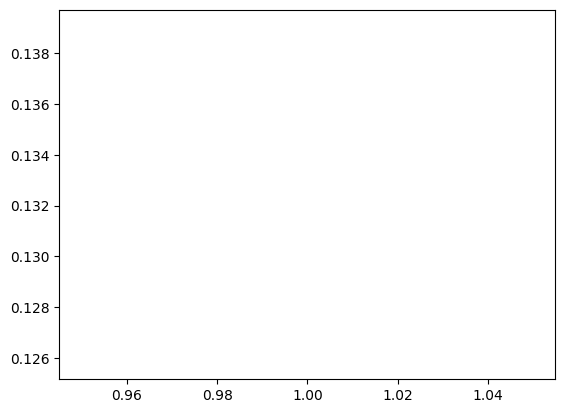

train Loss: 0.6776 ROC AUC: 0.5973
train Cohen Kappa: 0.1324, Accuracy: 0.5670, lr: 0.001000
val Loss: 0.6434 ROC AUC: 0.7027
val Cohen Kappa: 0.2761, Accuracy: 0.6394, lr: 0.001000
Epoch 1/99
----------
train Loss: 0.6376 ROC AUC: 0.6890
train Cohen Kappa: 0.2781, Accuracy: 0.6393, lr: 0.001000
val Loss: 0.6220 ROC AUC: 0.7104
val Cohen Kappa: 0.2972, Accuracy: 0.6484, lr: 0.001000
Epoch 2/99
----------
train Loss: 0.6215 ROC AUC: 0.7077
train Cohen Kappa: 0.2922, Accuracy: 0.6462, lr: 0.001000
val Loss: 0.6171 ROC AUC: 0.7241
val Cohen Kappa: 0.3274, Accuracy: 0.6617, lr: 0.001000
Epoch 3/99
----------
train Loss: 0.6073 ROC AUC: 0.7301
train Cohen Kappa: 0.3340, Accuracy: 0.6669, lr: 0.001000
val Loss: 0.6007 ROC AUC: 0.7406
val Cohen Kappa: 0.3492, Accuracy: 0.6739, lr: 0.001000
Epoch 4/99
----------
train Loss: 0.5985 ROC AUC: 0.7385
train Cohen Kappa: 0.3397, Accuracy: 0.6698, lr: 0.001000
val Loss: 0.5929 ROC AUC: 0.7519
val Cohen Kappa: 0.3653, Accuracy: 0.6835, lr: 0.001000
Ep

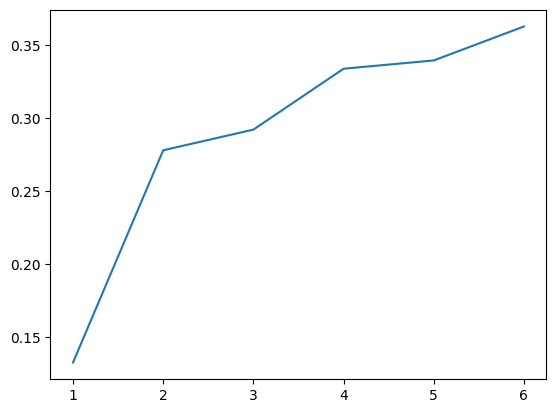

train Loss: 0.5925 ROC AUC: 0.7471
train Cohen Kappa: 0.3630, Accuracy: 0.6816, lr: 0.001000
val Loss: 0.6002 ROC AUC: 0.7543
val Cohen Kappa: 0.3761, Accuracy: 0.6856, lr: 0.001000
Epoch 6/99
----------
train Loss: 0.5859 ROC AUC: 0.7543
train Cohen Kappa: 0.3744, Accuracy: 0.6872, lr: 0.001000
val Loss: 0.5856 ROC AUC: 0.7583
val Cohen Kappa: 0.3588, Accuracy: 0.6787, lr: 0.001000
Epoch 7/99
----------
train Loss: 0.5820 ROC AUC: 0.7581
train Cohen Kappa: 0.3765, Accuracy: 0.6881, lr: 0.001000
val Loss: 0.5807 ROC AUC: 0.7636
val Cohen Kappa: 0.3828, Accuracy: 0.6914, lr: 0.001000
Epoch 8/99
----------
train Loss: 0.5786 ROC AUC: 0.7633
train Cohen Kappa: 0.3862, Accuracy: 0.6932, lr: 0.001000
val Loss: 0.5883 ROC AUC: 0.7677
val Cohen Kappa: 0.3842, Accuracy: 0.6899, lr: 0.001000
Epoch 9/99
----------
train Loss: 0.5734 ROC AUC: 0.7684
train Cohen Kappa: 0.3861, Accuracy: 0.6930, lr: 0.001000
val Loss: 0.5735 ROC AUC: 0.7726
val Cohen Kappa: 0.3966, Accuracy: 0.6978, lr: 0.001000
Ep

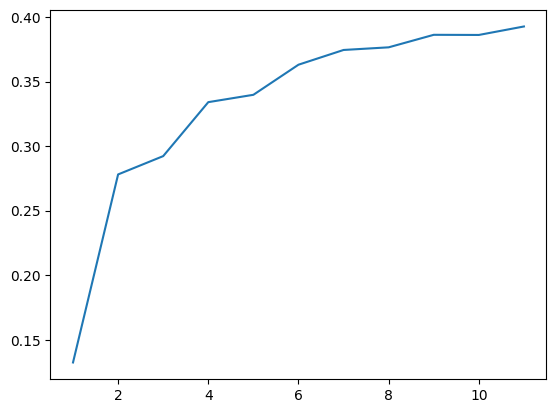

train Loss: 0.5696 ROC AUC: 0.7712
train Cohen Kappa: 0.3926, Accuracy: 0.6962, lr: 0.001000
val Loss: 0.5748 ROC AUC: 0.7716
val Cohen Kappa: 0.3925, Accuracy: 0.6973, lr: 0.001000
Epoch 11/99
----------
train Loss: 0.5704 ROC AUC: 0.7712
train Cohen Kappa: 0.3923, Accuracy: 0.6962, lr: 0.001000
val Loss: 0.5716 ROC AUC: 0.7750
val Cohen Kappa: 0.4049, Accuracy: 0.7015, lr: 0.001000
Epoch 12/99
----------
train Loss: 0.5636 ROC AUC: 0.7793
train Cohen Kappa: 0.4019, Accuracy: 0.7009, lr: 0.001000
val Loss: 0.5666 ROC AUC: 0.7789
val Cohen Kappa: 0.4079, Accuracy: 0.7037, lr: 0.001000
Epoch 13/99
----------
train Loss: 0.5597 ROC AUC: 0.7817
train Cohen Kappa: 0.4115, Accuracy: 0.7059, lr: 0.001000
val Loss: 0.6019 ROC AUC: 0.7811
val Cohen Kappa: 0.3771, Accuracy: 0.6851, lr: 0.001000
Epoch 14/99
----------
train Loss: 0.5593 ROC AUC: 0.7824
train Cohen Kappa: 0.4143, Accuracy: 0.7071, lr: 0.001000
val Loss: 0.5663 ROC AUC: 0.7789
val Cohen Kappa: 0.4133, Accuracy: 0.7063, lr: 0.00100

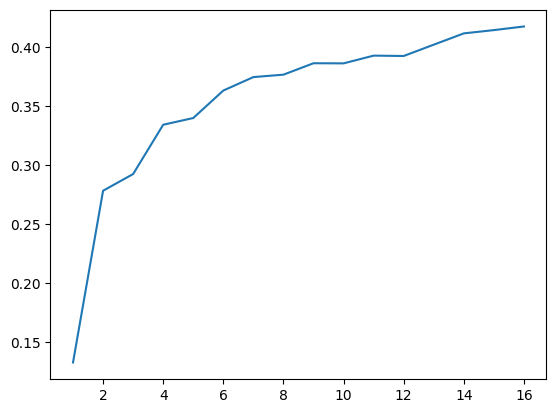

train Loss: 0.5579 ROC AUC: 0.7835
train Cohen Kappa: 0.4173, Accuracy: 0.7087, lr: 0.001000
val Loss: 0.5565 ROC AUC: 0.7895
val Cohen Kappa: 0.4385, Accuracy: 0.7191, lr: 0.001000
Epoch 16/99
----------
train Loss: 0.5569 ROC AUC: 0.7856
train Cohen Kappa: 0.4079, Accuracy: 0.7039, lr: 0.001000
val Loss: 0.5854 ROC AUC: 0.7876
val Cohen Kappa: 0.3383, Accuracy: 0.6729, lr: 0.001000
Epoch 17/99
----------
train Loss: 0.5518 ROC AUC: 0.7905
train Cohen Kappa: 0.4294, Accuracy: 0.7148, lr: 0.001000
val Loss: 0.5576 ROC AUC: 0.7910
val Cohen Kappa: 0.4295, Accuracy: 0.7159, lr: 0.001000
Epoch 18/99
----------
train Loss: 0.5519 ROC AUC: 0.7909
train Cohen Kappa: 0.4306, Accuracy: 0.7155, lr: 0.001000
val Loss: 0.5565 ROC AUC: 0.7929
val Cohen Kappa: 0.4335, Accuracy: 0.7153, lr: 0.001000
Epoch 19/99
----------
train Loss: 0.5484 ROC AUC: 0.7928
train Cohen Kappa: 0.4298, Accuracy: 0.7149, lr: 0.001000
val Loss: 0.5564 ROC AUC: 0.7980
val Cohen Kappa: 0.4156, Accuracy: 0.7095, lr: 0.00100

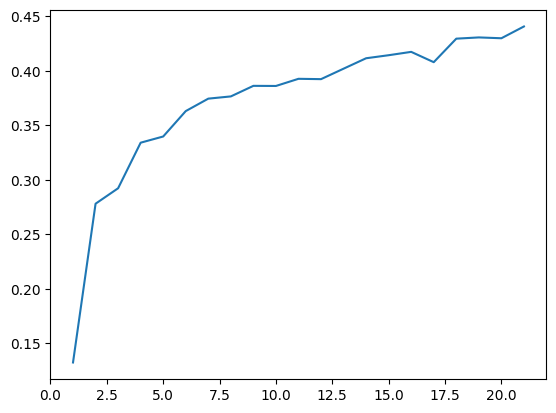

train Loss: 0.5443 ROC AUC: 0.7975
train Cohen Kappa: 0.4406, Accuracy: 0.7204, lr: 0.001000
val Loss: 0.5510 ROC AUC: 0.7966
val Cohen Kappa: 0.4415, Accuracy: 0.7196, lr: 0.001000
Epoch 21/99
----------
train Loss: 0.5419 ROC AUC: 0.7979
train Cohen Kappa: 0.4432, Accuracy: 0.7216, lr: 0.001000
val Loss: 0.5605 ROC AUC: 0.7990
val Cohen Kappa: 0.3930, Accuracy: 0.6989, lr: 0.001000
Epoch 22/99
----------
train Loss: 0.5392 ROC AUC: 0.8024
train Cohen Kappa: 0.4439, Accuracy: 0.7221, lr: 0.001000
val Loss: 0.5437 ROC AUC: 0.8018
val Cohen Kappa: 0.4461, Accuracy: 0.7223, lr: 0.001000
Epoch 23/99
----------
train Loss: 0.5383 ROC AUC: 0.8031
train Cohen Kappa: 0.4450, Accuracy: 0.7225, lr: 0.001000
val Loss: 0.5418 ROC AUC: 0.8024
val Cohen Kappa: 0.4501, Accuracy: 0.7249, lr: 0.001000
Epoch 24/99
----------
train Loss: 0.5394 ROC AUC: 0.8024
train Cohen Kappa: 0.4467, Accuracy: 0.7233, lr: 0.001000
val Loss: 0.5431 ROC AUC: 0.8013
val Cohen Kappa: 0.4471, Accuracy: 0.7233, lr: 0.00100

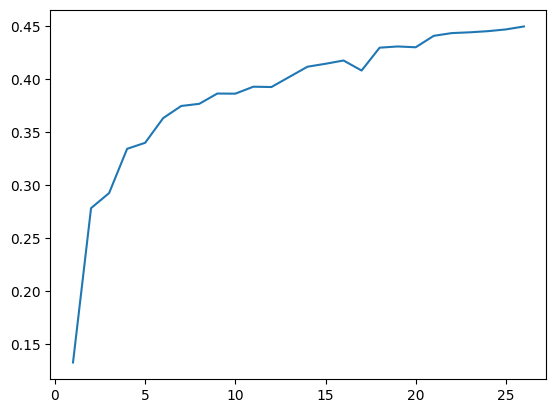

train Loss: 0.5402 ROC AUC: 0.8012
train Cohen Kappa: 0.4494, Accuracy: 0.7248, lr: 0.001000
val Loss: 0.5476 ROC AUC: 0.8052
val Cohen Kappa: 0.4277, Accuracy: 0.7153, lr: 0.001000
Epoch 26/99
----------
train Loss: 0.5330 ROC AUC: 0.8071
train Cohen Kappa: 0.4619, Accuracy: 0.7310, lr: 0.001000
val Loss: 0.5373 ROC AUC: 0.8075
val Cohen Kappa: 0.4642, Accuracy: 0.7313, lr: 0.001000
Epoch 27/99
----------
train Loss: 0.5300 ROC AUC: 0.8108
train Cohen Kappa: 0.4625, Accuracy: 0.7313, lr: 0.001000
val Loss: 0.5339 ROC AUC: 0.8097
val Cohen Kappa: 0.4687, Accuracy: 0.7345, lr: 0.001000
Epoch 28/99
----------
train Loss: 0.5295 ROC AUC: 0.8113
train Cohen Kappa: 0.4653, Accuracy: 0.7327, lr: 0.001000
val Loss: 0.5329 ROC AUC: 0.8106
val Cohen Kappa: 0.4658, Accuracy: 0.7323, lr: 0.001000
Epoch 29/99
----------
train Loss: 0.5337 ROC AUC: 0.8078
train Cohen Kappa: 0.4648, Accuracy: 0.7325, lr: 0.001000
val Loss: 0.5334 ROC AUC: 0.8109
val Cohen Kappa: 0.4618, Accuracy: 0.7313, lr: 0.00100

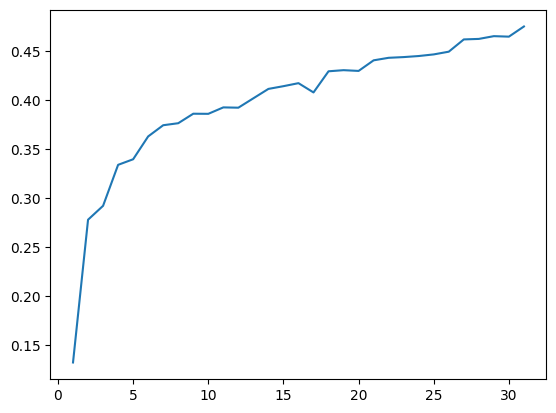

train Loss: 0.5246 ROC AUC: 0.8150
train Cohen Kappa: 0.4752, Accuracy: 0.7375, lr: 0.001000
val Loss: 0.5395 ROC AUC: 0.8087
val Cohen Kappa: 0.4431, Accuracy: 0.7228, lr: 0.001000
Epoch 31/99
----------
train Loss: 0.5252 ROC AUC: 0.8148
train Cohen Kappa: 0.4698, Accuracy: 0.7350, lr: 0.001000
val Loss: 0.5325 ROC AUC: 0.8121
val Cohen Kappa: 0.4708, Accuracy: 0.7345, lr: 0.001000
Epoch 32/99
----------
train Loss: 0.5280 ROC AUC: 0.8130
train Cohen Kappa: 0.4731, Accuracy: 0.7366, lr: 0.001000
val Loss: 0.5284 ROC AUC: 0.8132
val Cohen Kappa: 0.4731, Accuracy: 0.7361, lr: 0.001000
Epoch 33/99
----------
train Loss: 0.5218 ROC AUC: 0.8179
train Cohen Kappa: 0.4767, Accuracy: 0.7384, lr: 0.001000
val Loss: 0.5311 ROC AUC: 0.8162
val Cohen Kappa: 0.4528, Accuracy: 0.7276, lr: 0.001000
Epoch 34/99
----------
train Loss: 0.5189 ROC AUC: 0.8205
train Cohen Kappa: 0.4807, Accuracy: 0.7404, lr: 0.001000
val Loss: 0.5370 ROC AUC: 0.8135
val Cohen Kappa: 0.4464, Accuracy: 0.7217, lr: 0.00100

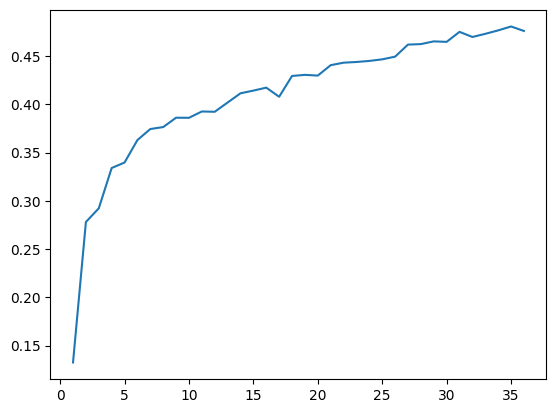

train Loss: 0.5211 ROC AUC: 0.8181
train Cohen Kappa: 0.4761, Accuracy: 0.7381, lr: 0.001000
val Loss: 0.5269 ROC AUC: 0.8188
val Cohen Kappa: 0.4611, Accuracy: 0.7313, lr: 0.001000
Epoch 36/99
----------
train Loss: 0.5201 ROC AUC: 0.8179
train Cohen Kappa: 0.4736, Accuracy: 0.7370, lr: 0.001000
val Loss: 0.5235 ROC AUC: 0.8206
val Cohen Kappa: 0.4828, Accuracy: 0.7419, lr: 0.001000
Epoch 37/99
----------
train Loss: 0.5163 ROC AUC: 0.8220
train Cohen Kappa: 0.4870, Accuracy: 0.7435, lr: 0.001000
val Loss: 0.5215 ROC AUC: 0.8193
val Cohen Kappa: 0.4827, Accuracy: 0.7414, lr: 0.001000
Epoch 38/99
----------
train Loss: 0.5180 ROC AUC: 0.8209
train Cohen Kappa: 0.4796, Accuracy: 0.7399, lr: 0.001000
val Loss: 0.5239 ROC AUC: 0.8204
val Cohen Kappa: 0.4717, Accuracy: 0.7366, lr: 0.001000
Epoch 39/99
----------
train Loss: 0.5181 ROC AUC: 0.8204
train Cohen Kappa: 0.4808, Accuracy: 0.7404, lr: 0.001000
val Loss: 0.5208 ROC AUC: 0.8199
val Cohen Kappa: 0.4831, Accuracy: 0.7414, lr: 0.00100

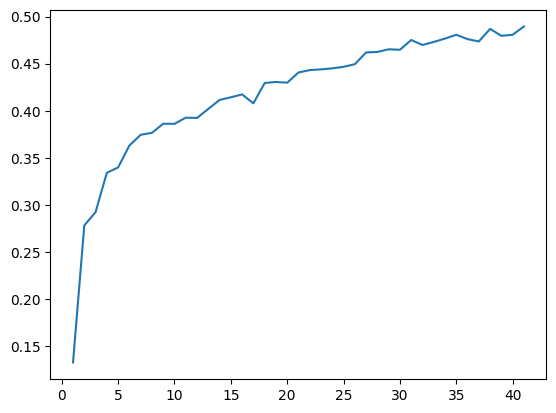

train Loss: 0.5146 ROC AUC: 0.8236
train Cohen Kappa: 0.4895, Accuracy: 0.7448, lr: 0.001000
val Loss: 0.5186 ROC AUC: 0.8233
val Cohen Kappa: 0.4819, Accuracy: 0.7403, lr: 0.001000
Epoch 41/99
----------
train Loss: 0.5096 ROC AUC: 0.8272
train Cohen Kappa: 0.4934, Accuracy: 0.7468, lr: 0.001000
val Loss: 0.5209 ROC AUC: 0.8266
val Cohen Kappa: 0.4862, Accuracy: 0.7419, lr: 0.001000
Epoch 42/99
----------
train Loss: 0.5105 ROC AUC: 0.8274
train Cohen Kappa: 0.4970, Accuracy: 0.7485, lr: 0.001000
val Loss: 0.5145 ROC AUC: 0.8273
val Cohen Kappa: 0.4936, Accuracy: 0.7472, lr: 0.001000
Epoch 43/99
----------
train Loss: 0.5146 ROC AUC: 0.8225
train Cohen Kappa: 0.4897, Accuracy: 0.7450, lr: 0.001000
val Loss: 0.5189 ROC AUC: 0.8247
val Cohen Kappa: 0.4920, Accuracy: 0.7467, lr: 0.001000
Epoch 44/99
----------
train Loss: 0.5105 ROC AUC: 0.8273
train Cohen Kappa: 0.4981, Accuracy: 0.7491, lr: 0.000200
val Loss: 0.5226 ROC AUC: 0.8265
val Cohen Kappa: 0.4793, Accuracy: 0.7408, lr: 0.00020

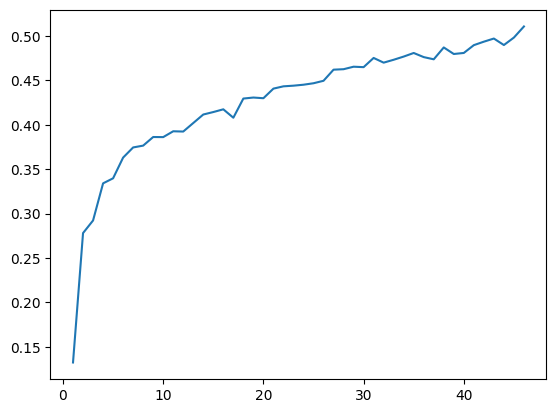

train Loss: 0.4941 ROC AUC: 0.8401
train Cohen Kappa: 0.5106, Accuracy: 0.7553, lr: 0.000200
val Loss: 0.5127 ROC AUC: 0.8284
val Cohen Kappa: 0.4991, Accuracy: 0.7499, lr: 0.000200
Epoch 46/99
----------
train Loss: 0.4983 ROC AUC: 0.8360
train Cohen Kappa: 0.5113, Accuracy: 0.7557, lr: 0.000200
val Loss: 0.5122 ROC AUC: 0.8282
val Cohen Kappa: 0.4898, Accuracy: 0.7446, lr: 0.000200
Epoch 47/99
----------
train Loss: 0.4943 ROC AUC: 0.8407
train Cohen Kappa: 0.5199, Accuracy: 0.7600, lr: 0.000200
val Loss: 0.5110 ROC AUC: 0.8289
val Cohen Kappa: 0.4896, Accuracy: 0.7446, lr: 0.000200
Epoch 48/99
----------
train Loss: 0.4936 ROC AUC: 0.8400
train Cohen Kappa: 0.5158, Accuracy: 0.7580, lr: 0.000200
val Loss: 0.5116 ROC AUC: 0.8284
val Cohen Kappa: 0.4966, Accuracy: 0.7477, lr: 0.000200
Epoch 49/99
----------
train Loss: 0.4943 ROC AUC: 0.8404
train Cohen Kappa: 0.5285, Accuracy: 0.7643, lr: 0.000200
val Loss: 0.5129 ROC AUC: 0.8283
val Cohen Kappa: 0.4935, Accuracy: 0.7461, lr: 0.00020

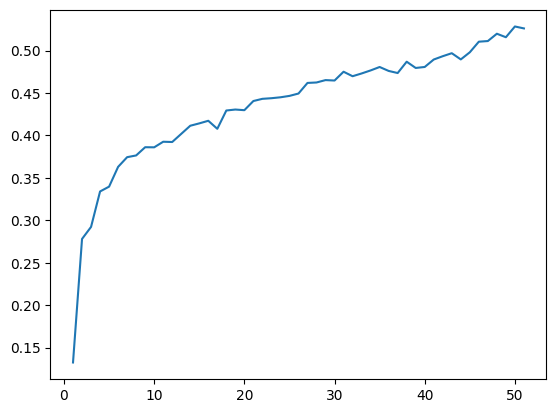

train Loss: 0.4919 ROC AUC: 0.8421
train Cohen Kappa: 0.5262, Accuracy: 0.7631, lr: 0.000200
val Loss: 0.5108 ROC AUC: 0.8294
val Cohen Kappa: 0.4976, Accuracy: 0.7483, lr: 0.000200
Epoch 51/99
----------
train Loss: 0.4946 ROC AUC: 0.8398
train Cohen Kappa: 0.5167, Accuracy: 0.7584, lr: 0.000200
val Loss: 0.5077 ROC AUC: 0.8309
val Cohen Kappa: 0.4946, Accuracy: 0.7472, lr: 0.000200
Epoch 52/99
----------
train Loss: 0.4926 ROC AUC: 0.8414
train Cohen Kappa: 0.5192, Accuracy: 0.7596, lr: 0.000200
val Loss: 0.5083 ROC AUC: 0.8305
val Cohen Kappa: 0.4930, Accuracy: 0.7467, lr: 0.000200
Epoch 53/99
----------
train Loss: 0.4915 ROC AUC: 0.8420
train Cohen Kappa: 0.5206, Accuracy: 0.7604, lr: 0.000200
val Loss: 0.5083 ROC AUC: 0.8299
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000200
Epoch 54/99
----------
train Loss: 0.4932 ROC AUC: 0.8403
train Cohen Kappa: 0.5242, Accuracy: 0.7621, lr: 0.000200
val Loss: 0.5103 ROC AUC: 0.8309
val Cohen Kappa: 0.4922, Accuracy: 0.7467, lr: 0.00020

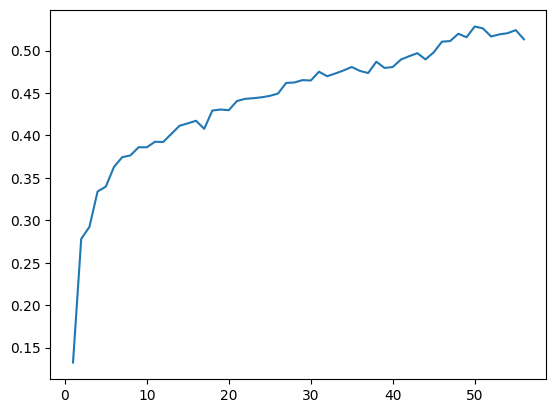

train Loss: 0.4917 ROC AUC: 0.8420
train Cohen Kappa: 0.5134, Accuracy: 0.7568, lr: 0.000200
val Loss: 0.5074 ROC AUC: 0.8310
val Cohen Kappa: 0.4981, Accuracy: 0.7488, lr: 0.000200
Epoch 56/99
----------
train Loss: 0.4875 ROC AUC: 0.8461
train Cohen Kappa: 0.5278, Accuracy: 0.7639, lr: 0.000200
val Loss: 0.5078 ROC AUC: 0.8317
val Cohen Kappa: 0.5038, Accuracy: 0.7515, lr: 0.000200
Epoch 57/99
----------
train Loss: 0.4896 ROC AUC: 0.8444
train Cohen Kappa: 0.5297, Accuracy: 0.7649, lr: 0.000200
val Loss: 0.5090 ROC AUC: 0.8312
val Cohen Kappa: 0.5040, Accuracy: 0.7515, lr: 0.000200
Epoch 58/99
----------
train Loss: 0.4927 ROC AUC: 0.8412
train Cohen Kappa: 0.5238, Accuracy: 0.7619, lr: 0.000200
val Loss: 0.5074 ROC AUC: 0.8323
val Cohen Kappa: 0.4969, Accuracy: 0.7488, lr: 0.000200
Epoch 59/99
----------
train Loss: 0.4847 ROC AUC: 0.8481
train Cohen Kappa: 0.5364, Accuracy: 0.7682, lr: 0.000200
val Loss: 0.5065 ROC AUC: 0.8324
val Cohen Kappa: 0.5005, Accuracy: 0.7499, lr: 0.00020

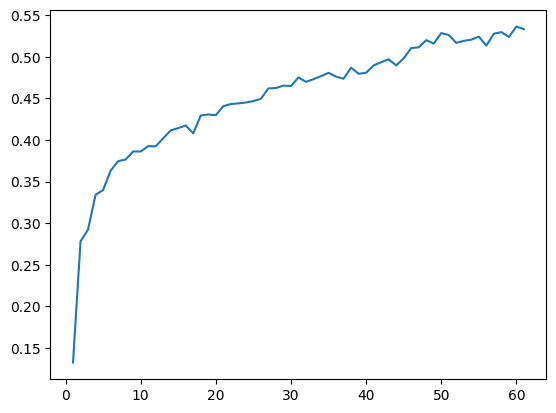

train Loss: 0.4889 ROC AUC: 0.8452
train Cohen Kappa: 0.5331, Accuracy: 0.7666, lr: 0.000200
val Loss: 0.5063 ROC AUC: 0.8330
val Cohen Kappa: 0.4915, Accuracy: 0.7461, lr: 0.000200
Epoch 61/99
----------
train Loss: 0.4921 ROC AUC: 0.8413
train Cohen Kappa: 0.5261, Accuracy: 0.7631, lr: 0.000200
val Loss: 0.5146 ROC AUC: 0.8323
val Cohen Kappa: 0.4925, Accuracy: 0.7451, lr: 0.000200
Epoch 62/99
----------
train Loss: 0.4922 ROC AUC: 0.8422
train Cohen Kappa: 0.5296, Accuracy: 0.7649, lr: 0.000040
val Loss: 0.5048 ROC AUC: 0.8333
val Cohen Kappa: 0.5068, Accuracy: 0.7531, lr: 0.000040
Epoch 63/99
----------
train Loss: 0.4835 ROC AUC: 0.8482
train Cohen Kappa: 0.5319, Accuracy: 0.7661, lr: 0.000040
val Loss: 0.5044 ROC AUC: 0.8336
val Cohen Kappa: 0.5047, Accuracy: 0.7520, lr: 0.000040
Epoch 64/99
----------
train Loss: 0.4877 ROC AUC: 0.8453
train Cohen Kappa: 0.5245, Accuracy: 0.7622, lr: 0.000040
val Loss: 0.5040 ROC AUC: 0.8337
val Cohen Kappa: 0.5034, Accuracy: 0.7515, lr: 0.00004

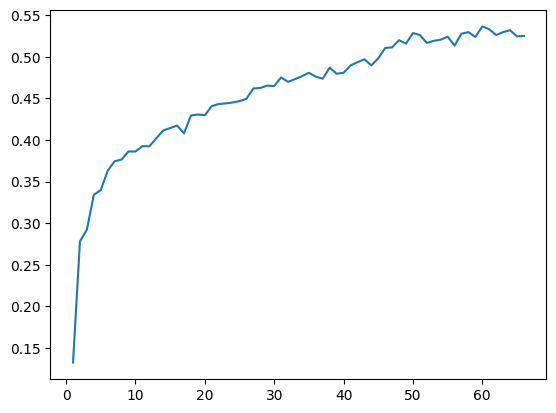

train Loss: 0.4846 ROC AUC: 0.8471
train Cohen Kappa: 0.5251, Accuracy: 0.7626, lr: 0.000040
val Loss: 0.5040 ROC AUC: 0.8337
val Cohen Kappa: 0.5024, Accuracy: 0.7509, lr: 0.000040
Epoch 66/99
----------
train Loss: 0.4880 ROC AUC: 0.8454
train Cohen Kappa: 0.5279, Accuracy: 0.7641, lr: 0.000008
val Loss: 0.5041 ROC AUC: 0.8338
val Cohen Kappa: 0.5046, Accuracy: 0.7520, lr: 0.000008
Epoch 67/99
----------
train Loss: 0.4833 ROC AUC: 0.8486
train Cohen Kappa: 0.5380, Accuracy: 0.7690, lr: 0.000008
val Loss: 0.5039 ROC AUC: 0.8338
val Cohen Kappa: 0.5035, Accuracy: 0.7515, lr: 0.000008
Epoch 68/99
----------
train Loss: 0.4852 ROC AUC: 0.8469
train Cohen Kappa: 0.5243, Accuracy: 0.7622, lr: 0.000008
val Loss: 0.5040 ROC AUC: 0.8338
val Cohen Kappa: 0.5068, Accuracy: 0.7531, lr: 0.000008
Epoch 69/99
----------
train Loss: 0.4808 ROC AUC: 0.8517
train Cohen Kappa: 0.5467, Accuracy: 0.7734, lr: 0.000008
val Loss: 0.5038 ROC AUC: 0.8339
val Cohen Kappa: 0.5035, Accuracy: 0.7515, lr: 0.00000

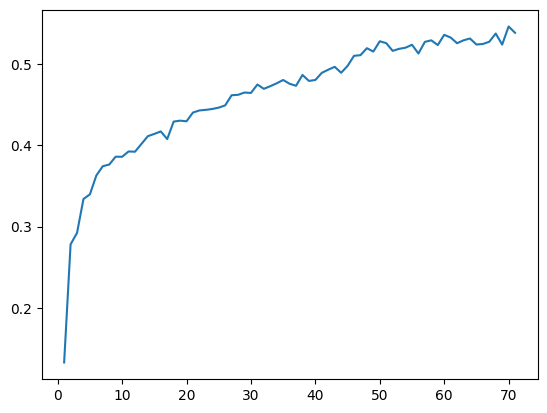

train Loss: 0.4878 ROC AUC: 0.8452
train Cohen Kappa: 0.5389, Accuracy: 0.7695, lr: 0.000008
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000008
Epoch 71/99
----------
train Loss: 0.4815 ROC AUC: 0.8504
train Cohen Kappa: 0.5442, Accuracy: 0.7722, lr: 0.000008
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5002, Accuracy: 0.7499, lr: 0.000008
Epoch 72/99
----------
train Loss: 0.4861 ROC AUC: 0.8469
train Cohen Kappa: 0.5458, Accuracy: 0.7730, lr: 0.000002
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000002
Epoch 73/99
----------
train Loss: 0.4857 ROC AUC: 0.8466
train Cohen Kappa: 0.5262, Accuracy: 0.7631, lr: 0.000002
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5024, Accuracy: 0.7509, lr: 0.000002
Epoch 74/99
----------
train Loss: 0.4833 ROC AUC: 0.8482
train Cohen Kappa: 0.5267, Accuracy: 0.7634, lr: 0.000002
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5024, Accuracy: 0.7509, lr: 0.00000

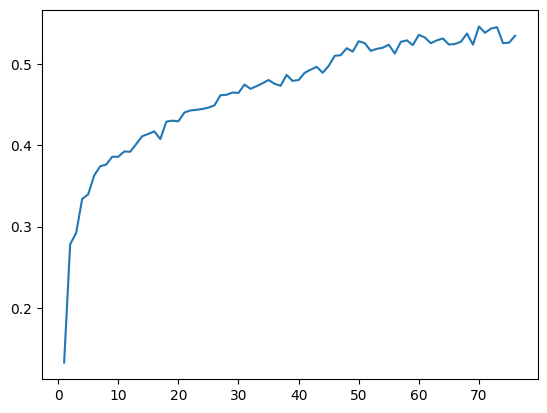

train Loss: 0.4821 ROC AUC: 0.8502
train Cohen Kappa: 0.5353, Accuracy: 0.7677, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 76/99
----------
train Loss: 0.4837 ROC AUC: 0.8484
train Cohen Kappa: 0.5294, Accuracy: 0.7647, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 77/99
----------
train Loss: 0.4882 ROC AUC: 0.8440
train Cohen Kappa: 0.5153, Accuracy: 0.7577, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 78/99
----------
train Loss: 0.4869 ROC AUC: 0.8452
train Cohen Kappa: 0.5269, Accuracy: 0.7635, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 79/99
----------
train Loss: 0.4816 ROC AUC: 0.8501
train Cohen Kappa: 0.5415, Accuracy: 0.7707, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.00000

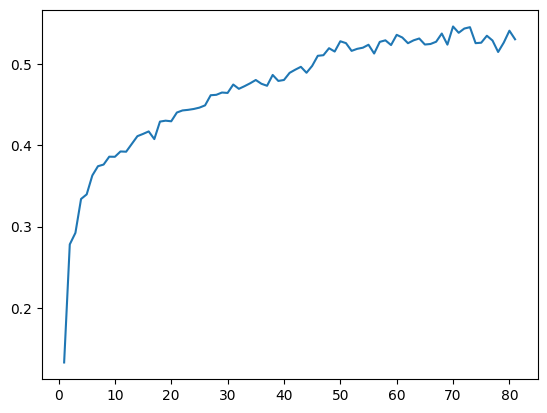

train Loss: 0.4836 ROC AUC: 0.8475
train Cohen Kappa: 0.5309, Accuracy: 0.7655, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 81/99
----------
train Loss: 0.4825 ROC AUC: 0.8501
train Cohen Kappa: 0.5374, Accuracy: 0.7687, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 82/99
----------
train Loss: 0.4841 ROC AUC: 0.8481
train Cohen Kappa: 0.5344, Accuracy: 0.7673, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 83/99
----------
train Loss: 0.4845 ROC AUC: 0.8477
train Cohen Kappa: 0.5353, Accuracy: 0.7677, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 84/99
----------
train Loss: 0.4845 ROC AUC: 0.8476
train Cohen Kappa: 0.5368, Accuracy: 0.7685, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.00000

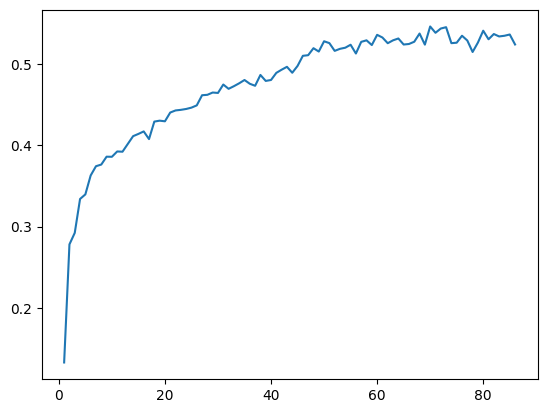

train Loss: 0.4864 ROC AUC: 0.8462
train Cohen Kappa: 0.5245, Accuracy: 0.7623, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 86/99
----------
train Loss: 0.4822 ROC AUC: 0.8487
train Cohen Kappa: 0.5335, Accuracy: 0.7667, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 87/99
----------
train Loss: 0.4837 ROC AUC: 0.8486
train Cohen Kappa: 0.5275, Accuracy: 0.7638, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 88/99
----------
train Loss: 0.4871 ROC AUC: 0.8449
train Cohen Kappa: 0.5232, Accuracy: 0.7617, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 89/99
----------
train Loss: 0.4835 ROC AUC: 0.8489
train Cohen Kappa: 0.5363, Accuracy: 0.7682, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.00000

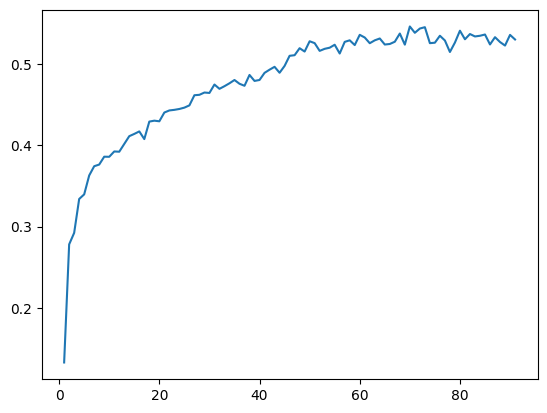

train Loss: 0.4843 ROC AUC: 0.8477
train Cohen Kappa: 0.5307, Accuracy: 0.7654, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 91/99
----------
train Loss: 0.4824 ROC AUC: 0.8498
train Cohen Kappa: 0.5414, Accuracy: 0.7707, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 92/99
----------
train Loss: 0.4775 ROC AUC: 0.8530
train Cohen Kappa: 0.5360, Accuracy: 0.7681, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 93/99
----------
train Loss: 0.4875 ROC AUC: 0.8454
train Cohen Kappa: 0.5294, Accuracy: 0.7647, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 94/99
----------
train Loss: 0.4825 ROC AUC: 0.8493
train Cohen Kappa: 0.5379, Accuracy: 0.7690, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.00000

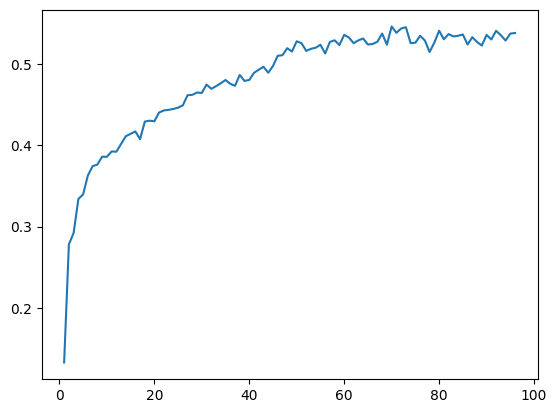

train Loss: 0.4845 ROC AUC: 0.8481
train Cohen Kappa: 0.5387, Accuracy: 0.7694, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 96/99
----------
train Loss: 0.4844 ROC AUC: 0.8470
train Cohen Kappa: 0.5200, Accuracy: 0.7601, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 97/99
----------
train Loss: 0.4829 ROC AUC: 0.8497
train Cohen Kappa: 0.5317, Accuracy: 0.7659, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 98/99
----------
train Loss: 0.4824 ROC AUC: 0.8484
train Cohen Kappa: 0.5248, Accuracy: 0.7625, lr: 0.000000
val Loss: 0.5037 ROC AUC: 0.8339
val Cohen Kappa: 0.5013, Accuracy: 0.7504, lr: 0.000000
Epoch 99/99
----------


KeyboardInterrupt: 

In [54]:

criterion = torch.nn.BCELoss()

datasets = {'train': train_loader,
            'val': val_loader}

datasets_sizes = {
    'train': len(train_dataset),
    'val': len(val_dataset)
}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

for name, model in model_dict.items():
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=.001)
    # Decay learning rate by a factor of 0.01 every 7 epochs
    exp_lr_scheduler = ReduceLROnPlateau(optimizer, 
                             mode='min',       # Surveille la diminution de la loss
                             factor=0.2,      # Réduction du LR par 2
                             patience=2,      # Nombre d'epochs sans amélioration avant réduction   # Affiche les messages de réduction,  # Seuil de changement significatif
) 

    model_out, optimizer, best_acc, best_loss, train_auprc, train_loss, val_auprc, val_loss = train_model(model,
                                                                                                  criterion,
                                                                                                  optimizer,
                                                                                                  exp_lr_scheduler,
                                                                                                  datasets,
                                                                                                  datasets_sizes,
                                                                                                  device,
                                                                                                  track_out=True,
                                                                                                  num_epochs=100)

    model_dict[name] = model_out
    model_results[name] = {
        'Train AUPRC': train_auprc,
        'Val AUPRC': val_auprc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    }

    # save model weights
    torch.save(model.state_dict(), r'weights/' + name + '_100.pt')

    # save metrics
    plot_metrics(train_loss, val_loss, train_auprc, val_auprc, save = r'figures/' + name)

## Run Conformal Risk Procedure

In [ ]:

load = False
# load in pretrained weights if they are not loaded already
if load:
    for name, model in model_dict.items():
        model.load_state_dict(torch.load('weights/' + name + "_100.pt"))

        model_dict[name] = model

In [ ]:
import seaborn as sns
from scipy.stats import beta

def plot_coverage(coverages, filename, names, n, l):

    f, axs = plt.subplots(nrows = 1, ncols = 3, sharex=True, figsize = (20, 5))

    for i, coverage in enumerate(coverages):

        mean = np.mean(coverage)

        # empirical quantiles
        lower_quant = np.quantile(coverage, 0.05)
        upper_quant =np.quantile(coverage, 0.95)

        # expected quantile from beta distribution
        lower_exp = beta.ppf(0.05,n + 1 - l,l)
        upper_exp = beta.ppf(0.95,n + 1 - l,l)


        axs[i].axvline(mean, color='g', linestyle='--')

        axs[i].axvline(lower_quant, color = 'b', linestyle='-')

        axs[i].axvline(lower_exp, color = 'r', linestyle='-')
        axs[i].axvline(upper_exp, color = 'r', linestyle='-')

        axs[i].legend({'Mean':mean, 'Empirical Quantile': upper_quant, 'Beta Quantile': upper_exp})

        axs[i].axvline(upper_quant, color = 'b', linestyle='-')
        sns.distplot(coverage, ax = axs[i], label =None)

        axs[i].set(title = names[i] + " Coverage",xlabel='')

    plt.savefig(filename)

### Validate distribution of coverages

In [ ]:
# check conformal inference coverage
i = 0
coverage_list = []
for name, model in model_dict.items():

    # get validation results
    val_probs, val_gt = inference_model(model, val_loader)

    scores = np.concatenate([np.array(val_probs), cal_scores[i]])

    gt = np.concatenate([np.array(val_gt), cal_gts[i]])

    n = len(cal_data)

    alpha = 0.1

    R = 10000

    coverages = np.zeros((R,))

    for r in range(R):
        np.random.shuffle(scores)
        temp_calib_scores, temp_val_scores = (scores[:n], scores[n:])
        qhat = np.quantile(temp_calib_scores, np.ceil((n + 1)*(1 - alpha))/n, interpolation = 'higher')
        coverages[r] = (temp_val_scores <= qhat).astype(float).mean()

    coverage_list.append(coverages)
    i += 1




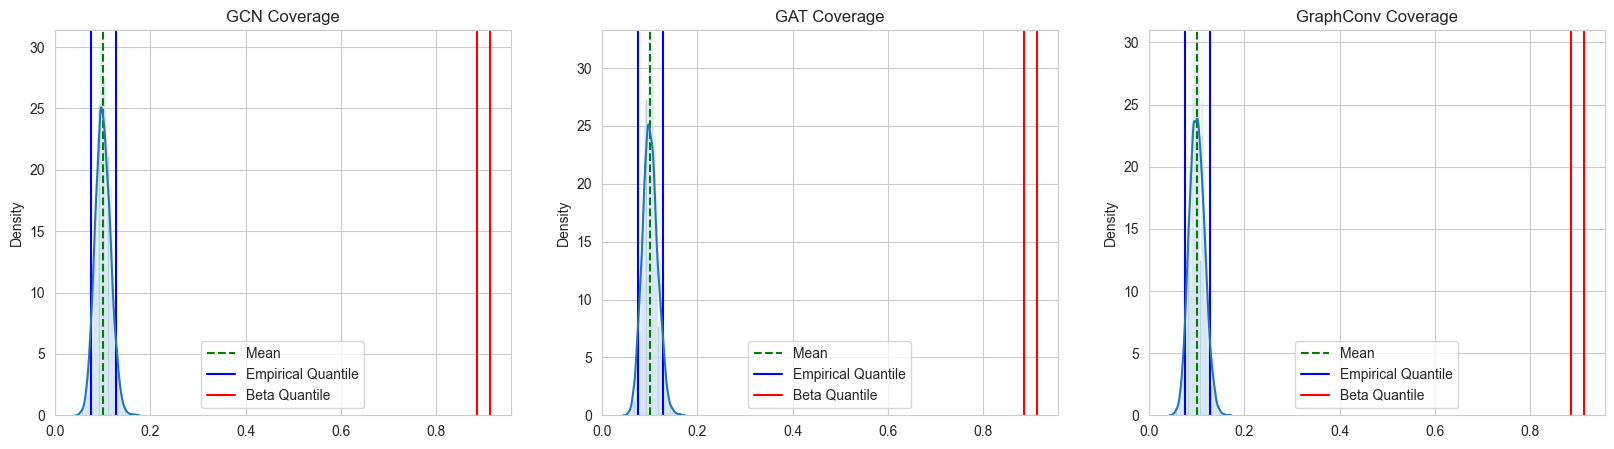

In [ ]:
l = np.floor((n + 1)*alpha)
plot_coverage(coverage_list,
              filename = 'figures/coverages.png',
              names = ["GCN", "GAT", "GraphConv"],
              n =n,
              l = l)

## Generate Metrics using threshold found using conformal risk procedure

In [ ]:
test_data = MoleculeDataset(transform = None, data_split = "test")
test_loader = DataLoader(train_data, batch_size=1, shuffle=False)

test_results = {}

for name, model in model_dict.items():
    test_probs, test_gt = inference_model(model, cal_loader)

    test_probs = np.array(test_probs)
    test_gt = np.array(test_gt)

    predicted_mols = test_probs >= conformal_res[name]

    # Calculate empirical FNR
    test_results[name] = {
        "FNR": false_negative_rate(predicted_mols, test_gt),
        "Accuracy": accuracy_score(test_gt, predicted_mols),
        "Precision": precision_score(test_gt, predicted_mols),
        "F1": f1_score(test_gt, predicted_mols)
    }


Found local copy...
Loading...
Done!
100%|██████████| 13445/13445 [00:09<00:00, 1388.02it/s]
 Oversample of minority class is used. 


In [ ]:
# note that these outputs are 0.099 instead of 0.1 to be conservative
# as discussed in A Gentle Introduction to Conformal Inference
for name, res in test_results.items():
    print(name)
    print(res)

GCN
{'FNR': 0.09930616617202759, 'Accuracy': 0.6707757704569607, 'Precision': 0.6114218428024728, 'F1': 0.7283885674206558}
GAT
{'FNR': 0.09930616617202759, 'Accuracy': 0.6704569606801275, 'Precision': 0.6111519788141827, 'F1': 0.728197037426593}
GraphConv
{'FNR': 0.09930616617202759, 'Accuracy': 0.8336875664187035, 'Precision': 0.7895837293290249, 'F1': 0.8414868834194267}


In [ ]:
print(conformal_res)

{'GCN': 0.3412226587533847, 'GAT': 0.34210424125151084, 'GraphConv': 0.46471627056520315}
